<a href="https://colab.research.google.com/github/AlessandroTenani02/work-dump/blob/main/KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means

---



Carico il dataset

In [ ]:
!pip install cleantext
import math
import numpy as np
import cleantext
import torch
import torch.nn as nn
import torchtext
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

url = 'https://raw.githubusercontent.com/niccosala-st/Text-Processing/main/spam_text_messages.csv'
df = pd.read_csv(url)

Processo il dataset con cleantext. Aggiungo la colonna 'Cleaned'.

In [ ]:
def clean_text(text_list):
    messages = []

    for message in text_list:
        corpus = cleantext.clean_words(message,
                              clean_all= False,    # Execute all cleaning operations
                              extra_spaces=True,   # Remove extra white spaces
                              stemming=True,       # Stem the words
                              stopwords=True,      # Remove stop words
                              lowercase=True,      # Convert to lowercase
                              numbers=False,       # Remove all digits
                              punct=True,          # Remove all punctuations
                              stp_lang='english'   # Language
        )
        cleaned_message = ' '.join(corpus)
        cleaned_message = re.sub("([\w\.\-\_]+@[\w\.\-\_]+)", "<EMAIL>", cleaned_message)
        cleaned_message = re.sub("(\d+)", "<NUMBER>", cleaned_message)
        cleaned_message = re.sub("(http\S+)", "<URL>", cleaned_message)
        cleaned_message = re.sub("(\s){2,}", "", cleaned_message)

        messages.append(cleaned_message)


    return messages

In [ ]:
df['Cleaned'] = clean_text(df['Message'])
df.head(20)

,Category,Message,Cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri <NUMBER> wkli comp win fa cup final...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darl <NUMBER> week word back id li...
6,ham,Even my brother is not like to speak with me. ...,even brother like speak treat like aid patent
7,ham,As per your request 'Melle Melle (Oru Minnamin...,per request mell mell oru minnaminungint nurun...
8,spam,WINNER!! As a valued network customer you have...,winner valu network custom select receivea £<N...
9,spam,Had your mobile 11 months or more? U R entitle...,mobil <NUMBER> month u r entitl updat latest c...


Mappo le labels. <br>
*   *ham*: 0
*   *spam*: 1

In [ ]:
label_mapping = {'ham': 0, 'spam': 1}
df['Labels'] = df['Category'].map(label_mapping)

Per dividere in clusters un dataset basato sul testo, è necessario che ogni messaggio sia caratterizzato da una sua rappresentazione numerica. <br>
Questo si può fare in diversi modi.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cluster

## 1. TF-IDF Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
input = tfidf_vectorizer.fit_transform(df['Cleaned'])
print(tfidf_vectorizer.get_feature_names_out())
print(input.shape)

['aa' 'aah' 'aaniy' ... 'zyada' 'üll' '〨ud']
(5572, 6969)


### 1.1. Distanza euclidea

In [ ]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(input)

predicted_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Calcolo le metriche di precisione.

In [ ]:
accuracy = accuracy_score(df['Labels'], predicted_labels)
precision = precision_score(df['Labels'], predicted_labels, average='weighted')
recall = recall_score(df['Labels'], predicted_labels, average='weighted')
f1 = f1_score(df['Labels'], predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9423905240488155
Precision: 0.944103383464413
Recall: 0.9423905240488155
F1 Score: 0.9431280800705948


Calcolo la purity del cluster.

In [ ]:
def purity(y_true, y_pred):

    cmat = cluster.contingency_matrix(y_true, y_pred)

    maxs = np.apply_along_axis(np.max, axis=1, arr=cmat)
    purity = np.sum(maxs)/np.sum(cmat)

    return purity

In [ ]:
purity(df['Labels'], predicted_labels)

0.9423905240488155

Visualizzo i cluster <br> (2 caratteristiche su duemila tutte simili, il plot più stupido della Terra)

[[7.35083177e-05 3.07131177e-04 2.06424063e-05 ... 3.54674346e-05
  3.06316276e-04 8.35460347e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
[[-0.07220755 -0.02114381]
 [-0.08460236  0.26524107]
 [ 0.35125131 -0.00192705]
 ...
 [-0.06908866 -0.01666082]
 [-0.06133902 -0.02893806]
 [-0.06979931 -0.01994224]]


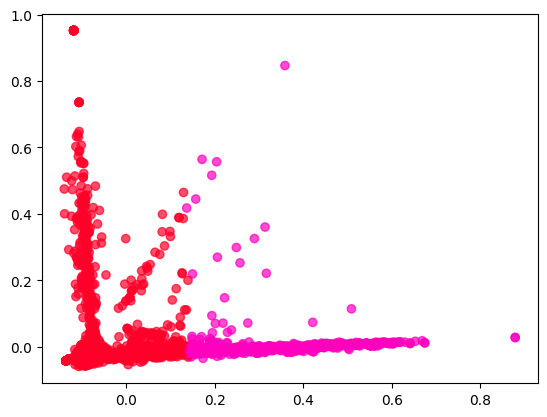

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

centroids = kmeans_e.cluster_centers_

print(centroids)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(input.toarray())

print(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='gist_rainbow', alpha=0.7)


## 2. *HugginFace* Embeddings

### 2.1. Distanza euclidea

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer ('multi-qa-MiniLM-L6-cos-v1')
embeddings = model.encode(df['Cleaned'])

for sentence, embedding in zip(df['Cleaned'], embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print()

Output streaming troncato alle ultime 5000 righe.
Embedding: [-3.38079520e-02 -2.45451741e-02  3.75280455e-02  8.81129876e-02
  4.77116415e-03 -1.95821491e-03 -5.79505041e-03  6.38063811e-03
  1.19255587e-01 -5.33612892e-02 -2.60053072e-02 -4.08535749e-02
 -2.47999877e-02 -4.81985956e-02  3.86603363e-02  1.24637615e-02
 -6.08753413e-03 -4.93660830e-02 -2.56017651e-02 -1.85816903e-02
  4.54030558e-02  8.97127092e-02  8.80205706e-02  4.62297164e-02
 -1.90867055e-02  1.92177221e-02  2.34153890e-03 -4.52243797e-02
  6.11508377e-02 -1.51786190e-02 -5.57934418e-02  9.60444137e-02
 -4.79144888e-04 -1.09343089e-01 -1.05168615e-02  1.00553490e-01
 -1.55766550e-02 -2.22690478e-02 -4.70313989e-02 -1.19674252e-02
 -4.26504090e-02 -6.98886588e-02 -8.69978871e-03  1.06319063e-03
  2.27563139e-02 -1.95226669e-02 -7.46215135e-02 -6.00768402e-02
 -1.39349652e-02  4.41713817e-02  1.82733294e-02 -5.09331061e-04
 -9.53009948e-02  1.12344259e-02 -1.75116044e-02  5.84498513e-03
 -1.73235778e-02  5.19171543e

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Output streaming troncato alle ultime 5000 righe.
Sentence: sent score sopha secondari applic school think think appli research cost also contact joke ogunrind school one less expens one
Embedding: [-1.77135915e-02  1.05817709e-02 -2.00653076e-02 -1.32243102e-02
  9.74860694e-03  4.66399118e-02  5.35492562e-02  3.99728380e-02
  8.31742883e-02  2.19322294e-02  6.57992251e-03 -6.33196309e-02
  5.51364608e-02 -2.94058733e-02  1.34343281e-02  1.41950895e-03
  1.00599797e-02 -8.07445217e-03 -6.98104799e-02 -9.04608667e-02
  2.88813990e-02  1.93557870e-02  9.29569229e-02  5.69393821e-02
  8.31003562e-02  2.49470063e-02 -6.43687472e-02 -4.41159233e-02
  1.96536761e-02  2.21802257e-02  3.81664075e-02  1.43759832e-01
 -2.50074621e-02  2.29039732e-02  1.67898592e-02 -3.15655163e-03
  3.19378544e-03  5.48632145e-02  1.96942147e-02  9.06526204e-03
 -4.37354520e-02 -5.63464351e-02 -9.04630031e-03 -3.98715287e-02
  5.93658909e-02 -4.14166972e-02 -8.98916125e-02 -3.06717530e-02
 -1.43277403e-02  2.39

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Output streaming troncato alle ultime 5000 righe.
Sentence: got ga money chanc gang want go grand natur adventur
Embedding: [-7.37967491e-02  8.22968595e-03 -3.69937234e-02  1.29307061e-03
 -6.54024035e-02 -5.71052544e-03  1.14304096e-01 -4.08854000e-02
 -2.13911794e-02 -6.41616352e-04 -1.80065539e-02 -5.60643105e-03
  5.74538298e-03 -3.02548278e-02  7.20880255e-02 -2.22611260e-02
  4.83801179e-02 -5.28070703e-02 -8.46935622e-03 -1.04959182e-01
 -1.55839035e-02 -8.82951990e-02 -6.54770946e-03  3.32591459e-02
 -2.07363209e-03 -6.39452459e-03  3.42069124e-03  2.86727715e-02
  7.34152198e-02 -2.16141026e-02  2.83993874e-02  6.60601631e-02
 -9.29798633e-02  3.64377014e-02 -3.79344448e-02 -1.71248952e-03
  1.94314960e-02 -3.40476744e-02  3.52018923e-02  1.33799380e-02
  5.90501651e-02 -1.46801677e-02 -3.29221529e-03  1.96891353e-02
 -6.69412129e-03  6.74255472e-03 -1.47425421e-02  3.07634808e-02
  2.98377126e-02 -2.65730619e-02  8.61023813e-02 -3.29622999e-02
 -2.48091985e-02  6.62614405e-0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Output streaming troncato alle ultime 5000 righe.
  1.46514308e-02 -3.39094698e-02  3.82838119e-03 -3.33737470e-02
  3.73171805e-03 -3.06585059e-02  1.31296655e-02 -2.48420071e-02]

Sentence: shop till u drop either <NUMBER>k <NUMBER>k £<NUMBER> cash £<NUMBER> travel voucher call <NUMBER> ntt po box cr<NUMBER>bt fixedlin cost <NUMBER>ppm mobil vari
Embedding: [-3.01071480e-02 -2.89316177e-02 -4.12012450e-03  3.66845317e-02
 -2.55085509e-02 -1.55006247e-02  9.46713537e-02  3.57024334e-02
  5.40478155e-02 -3.97501178e-02  2.07112860e-02 -6.80598170e-02
 -2.01517511e-02 -3.27359997e-02  4.65212911e-02  1.93685144e-02
 -2.35239733e-02 -2.42511667e-02 -4.13239077e-02 -9.10408273e-02
  1.58881471e-02 -2.48232540e-02 -5.65778986e-02  3.13962698e-02
 -2.93720067e-02  2.23600417e-02  4.15932424e-02  6.82219118e-02
  5.66218980e-02 -3.15646827e-02 -3.05080563e-02  5.90447783e-02
  1.01388162e-02  1.12662755e-03  1.55061549e-02  3.48451249e-02
 -2.36607771e-02 -4.06096987e-02  5.80309704e-02 -6.9

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Output streaming troncato alle ultime 5000 righe.
Sentence: ok lor buy wat
Embedding: [-7.11216405e-02 -3.29613220e-03  7.06847943e-03 -1.14477915e-03
 -4.48641926e-02  2.98834909e-02  9.15909484e-02 -3.25395204e-02
  4.17198800e-02  4.83577140e-03  4.19200920e-02 -4.48922701e-02
 -2.47983858e-02 -2.10365895e-02  4.78990786e-02 -6.79014847e-02
  3.71986665e-02 -2.23298632e-02 -1.11335017e-01 -9.82580632e-02
 -2.81474069e-02 -8.49675685e-02  3.84893268e-02  1.36315916e-03
 -8.49853829e-02  3.30759622e-02  7.96051323e-03  3.52111645e-02
  9.52814594e-02 -8.67353231e-02  8.16982388e-02  4.02269177e-02
 -4.53440025e-02 -5.75391017e-03 -4.81820069e-02 -6.78282306e-02
 -1.24823200e-02 -4.21898365e-02 -2.84945499e-02  2.80766599e-02
 -2.37586200e-02 -2.69068908e-02 -3.18625681e-02  9.35958605e-03
 -3.92703293e-03  6.11274056e-02  2.12078225e-02  2.37564743e-02
  5.04311845e-02  2.76334602e-02 -4.45003156e-03  9.22226440e-03
 -2.63678674e-02 -2.55668033e-02  2.37158779e-02  2.67503075e-02
 -1.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Output streaming troncato alle ultime 5000 righe.
Sentence: im gonna rip uteru
Embedding: [-4.80351001e-02 -4.55879867e-02 -7.71431718e-03 -6.30382001e-02
 -1.18785113e-01  2.72401497e-02  3.68321389e-02  2.99905390e-02
  4.72192094e-02  4.49253507e-02 -7.30135962e-02 -1.53142214e-01
  4.70292196e-02  1.35127800e-02  1.67082399e-02 -1.98159320e-03
  8.45016986e-02  1.76391564e-02 -4.43249792e-02 -5.64876758e-03
 -2.83024982e-02  5.06516546e-03 -1.96438283e-02  1.90888699e-02
  6.70617027e-03 -2.24990807e-02  8.07317812e-03  5.09836450e-02
 -3.14320289e-02 -7.76188001e-02  6.94311857e-02 -8.03092942e-02
 -8.04213881e-02 -8.55754241e-02  2.09308024e-02 -2.34450698e-02
  1.94601659e-02 -6.22337498e-02  6.78398386e-02  3.43977064e-02
  3.20163928e-02  2.39904784e-02  1.37909846e-02  2.06916332e-02
  6.45011812e-02  2.38112621e-02 -2.42825914e-02 -6.65390193e-02
  5.56574650e-02  1.64900813e-02  4.39433418e-02  8.03897977e-02
 -2.19657179e-03  8.02916139e-02  1.60341132e-02 -7.08557591e-02


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Output streaming troncato alle ultime 5000 righe.
Sentence: ye come nyc audiit tri reloc
Embedding: [ 9.43143964e-02 -6.24912232e-02 -3.01431213e-02  2.31239833e-02
 -1.11493364e-01  3.60211246e-02  1.18109742e-02 -9.66561884e-02
 -5.95158860e-02 -2.42695920e-02  4.26814556e-02 -8.08242410e-02
 -2.00635158e-02  5.31883771e-03  3.98970917e-02 -7.48734968e-03
  7.88059160e-02 -6.55709207e-02  1.18303448e-02  1.66518614e-02
 -6.66037109e-03 -2.68119369e-02 -2.15499699e-02  3.47858965e-02
 -2.20537633e-02  1.92578528e-02 -3.60020176e-02  6.47071823e-02
  4.01840284e-02 -5.50650395e-02  1.29684862e-02  4.32521477e-02
 -5.47897890e-02 -5.89941442e-02  1.07924342e-01  4.42278630e-04
  3.60216685e-02 -3.11014941e-04  1.22013306e-02  8.18593353e-02
 -4.43223752e-02 -3.32418159e-02 -2.39560455e-02  8.64886343e-02
  3.63889895e-02  6.12203702e-02 -1.02005620e-02 -1.87872387e-02
  8.35928484e-04  2.81689093e-02  5.52692115e-02  3.23880203e-02
  1.06544970e-02 -2.45290305e-02  5.59010718e-04  4.178

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Output streaming troncato alle ultime 5000 righe.
Sentence: marvel mobil play offici ultim spiderman game £<NUMBER> ur mobil right text spider <NUMBER> game send u free <NUMBER>ball wallpap
Embedding: [-6.12563007e-02  2.57299151e-02 -5.13266586e-02 -2.64211576e-02
 -3.79180200e-02  2.80422028e-02  2.21772958e-02  1.00462930e-02
  1.66562479e-02  2.27560159e-02 -4.85258624e-02 -7.96843544e-02
  2.19285116e-03 -2.66098492e-02  7.69395083e-02  1.65389292e-02
  4.22249623e-02 -1.02916472e-02  1.45469839e-02 -4.19815350e-03
  7.25069419e-02 -2.71727815e-02 -1.05234841e-02  4.59327213e-02
 -1.99258123e-02  4.35659774e-02  1.56547409e-02  1.77771877e-02
 -3.08810291e-03 -1.66964866e-02  5.34377806e-02  3.09380218e-02
  3.96869108e-02 -6.14877194e-02 -1.34693906e-02 -4.65556011e-02
 -5.87632507e-02 -3.97220924e-02 -5.10344617e-02 -6.73927069e-02
 -3.31185237e-02 -6.27099127e-02 -6.98440820e-02 -2.77131679e-03
 -4.13280353e-03  3.97698879e-02 -7.63933510e-02  4.91940305e-02
  2.64857579e-02 -3

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
kmeans_e = KMeans(n_clusters=2)
kmeans_e.fit(embeddings)

predicted_labels = kmeans_e.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Calcolo le metriche di precisione.

In [ ]:
accuracy = accuracy_score(df['Labels'], predicted_labels)
precision = precision_score(df['Labels'], predicted_labels, average='weighted')
recall = recall_score(df['Labels'], predicted_labels, average='weighted')
f1 = f1_score(df['Labels'], predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8124551328068916
Precision: 0.9116280209623938
Recall: 0.8124551328068916
F1 Score: 0.8387682237352853


Calcolo la purity.

In [ ]:
purity(df['Labels'], predicted_labels)

0.8124551328068916

Visualizzo i cluster.

[[ 0.01263872  0.13334614]
 [-0.2079967   0.21964051]
 [ 0.39091596  0.00993927]
 ...
 [-0.27597836 -0.00564534]
 [ 0.04730458  0.00869852]
 [-0.00341384 -0.23392299]]


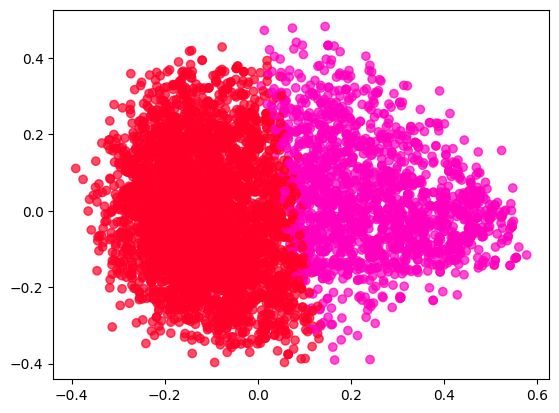

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(embeddings)

print(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='gist_rainbow', alpha=0.7)
